# Não espacial Sul  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/cluster_sul.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
dados_br = cod_dados.merge(seguro, how='left')

In [19]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

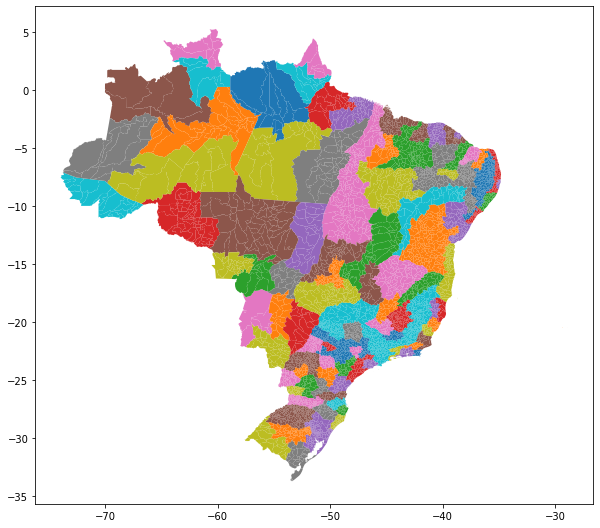

In [20]:
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Sul

In [21]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

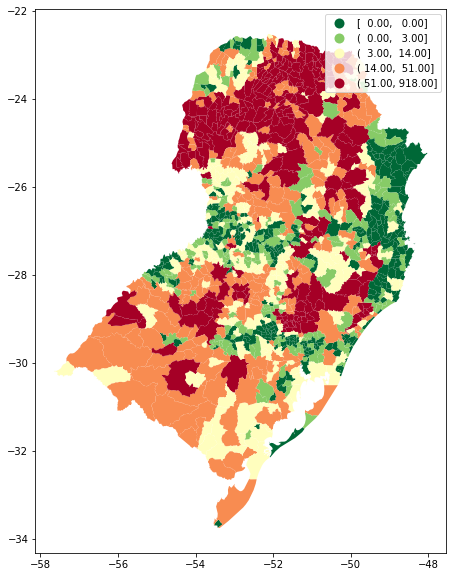

In [22]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

In [23]:
dados_sul.columns

Index(['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [24]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'rm', 'Unnamed: 0'] # , 'geometry'
dados_cluster_sul = dados_sul.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides - Sul

In [25]:
# subselecionar variáveis
X = scale(dados_cluster_sul.drop(['nome_mun', 'geometry'], axis=1))
# mudar o tipo dos dados
X = np.asarray(X, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [26]:
Z = linkage(X, method='ward')

In [27]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

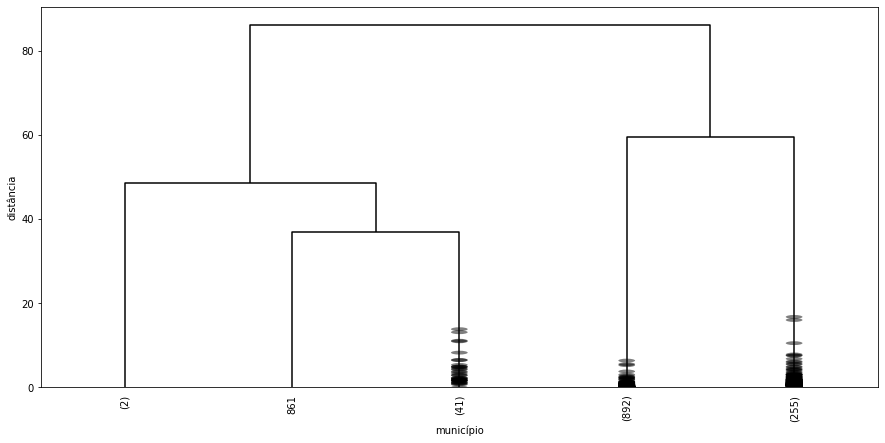

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [29]:
Z = linkage(X, method='ward')

In [30]:
## definir a distância de corte baseando no dendrograma
max_d = 20
grupos = cut_tree(Z, height=max_d)

### Métricas

In [31]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

1011.52 0.94 0.62


In [32]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_cluster_sul['grupo'] = grupos
# moran_matrix.head(2)

In [33]:
# contagem de observações em cada grupo
dados_cluster_sul.grupo.value_counts()

1    892
0    168
3     87
2     30
4     11
5      2
6      1
Name: grupo, dtype: int64

In [34]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_cluster_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,70.809524,1.059532e+07,7.683162e+05,3.319217e+05,6.506978e+05,16812.101726,1151.942202,17.648810
1,8.118834,1.326325e+06,8.785393e+04,3.723090e+04,3.577103e+04,1655.568285,191.923980,1.082960
2,272.500000,3.639408e+07,3.049377e+06,1.325811e+06,3.925084e+06,52353.061000,2778.556000,96.400000
3,122.643678,1.937076e+07,1.531630e+06,6.686953e+05,1.702451e+06,38332.208506,1998.042414,41.390805
4,427.454545,4.166161e+07,2.975459e+06,1.327313e+06,1.056992e+07,49788.270000,1812.797273,245.363636
5,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000
6,918.000000,8.732306e+07,6.465593e+06,2.909516e+06,3.700306e+07,72396.460000,2341.400000,771.000000


In [35]:
# mediana das variáveis para cada grupo
dados_cluster_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,59.5,9.359965e+06,7.401880e+05,318938.290,4.971034e+05,16274.50,1072.540,14.0
1,2.0,2.761259e+05,1.793924e+04,7786.455,0.000000e+00,0.00,86.075,0.0
2,275.0,3.186960e+07,2.743607e+06,1225166.870,3.625327e+06,52543.87,2919.795,95.5
3,119.0,1.712127e+07,1.337610e+06,592007.050,1.438069e+06,39897.40,1940.960,36.0
4,390.0,4.292863e+07,2.706815e+06,1210301.910,8.810961e+06,42295.14,1688.720,250.0
5,487.0,1.557418e+08,2.156674e+07,9364997.510,2.660479e+06,12995.41,2057.350,57.0
6,918.0,8.732306e+07,6.465593e+06,2909515.950,3.700306e+07,72396.46,2341.400,771.0


### As observações de cada grupo

In [36]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides Sul

In [37]:
dados_cluster_sul['grupo'] = dados_cluster_sul['grupo'].astype('category')

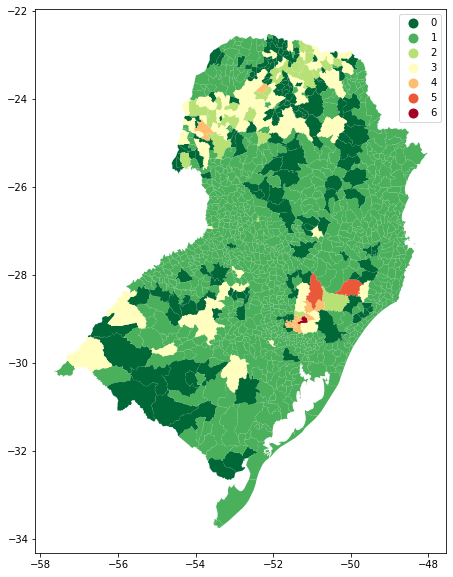

In [38]:
dados_cluster_sul.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

## K-Médias - Sul

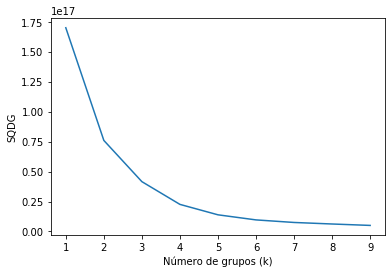

In [39]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_cluster_sul.drop(['nome_mun', 'geometry'], axis=1))
    dados_cluster_sul['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [40]:
k = 4

In [41]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [42]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_cluster_sul['grupo'] = kmeans.labels_

### Métricas

In [43]:
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

984.81 0.75 0.7


In [44]:
# contagens
dados_cluster_sul.grupo.value_counts()

0    968
1    193
3     28
2      2
Name: grupo, dtype: int64

In [45]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_cluster_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,11.988636,2.035716e+06,1.344514e+05,5.696181e+04,6.686180e+04,2392.476198,238.761715,1.811983,0.949380
1,110.834197,1.558728e+07,1.233959e+06,5.402259e+05,1.406700e+06,31128.523575,1789.070881,36.787565,5.373057
2,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,5.000000
3,378.821429,4.667342e+07,3.681017e+06,1.608249e+06,8.005276e+06,53679.978214,2420.678571,180.000000,3.178571


In [46]:
# mediana das variáveis para cada grupo
dados_cluster_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,3.0,3.612840e+05,26682.24,11116.355,0.00,0.00,111.015,0.0,0
1,97.0,1.289991e+07,1044391.85,454659.990,1081242.32,30494.00,1714.250,29.0,7
2,487.0,1.557418e+08,21566742.09,9364997.510,2660478.72,12995.41,2057.350,57.0,5
3,339.0,4.347939e+07,3602107.12,1562343.220,5931502.50,54738.50,2407.085,135.0,2


In [47]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides K-médias Sul

In [48]:
dados_cluster_sul['grupo'] = dados_cluster_sul['grupo'].astype('category')

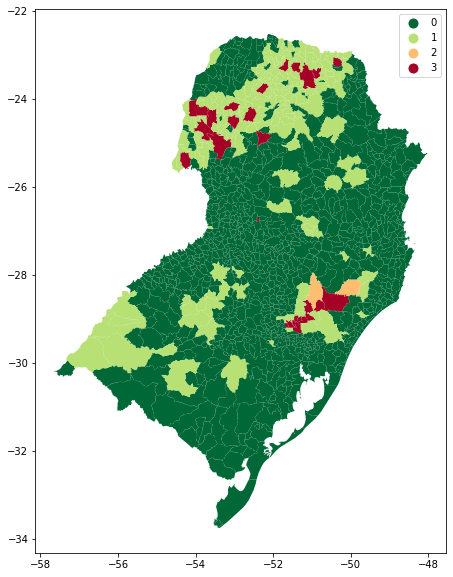

In [49]:
dados_cluster_sul.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering

In [50]:
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [51]:
model = AgglomerativeClustering(distance_threshold=20, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<1191x1191 sparse matrix of type '<class 'numpy.float64'>'
	with 5942 stored elements in Compressed Sparse Row format>,
                        distance_threshold=20, linkage='ward', memory=None,
                        n_clusters=None)

In [52]:
dados_cluster_sul['grupo'] = model.labels_

In [53]:
dados_cluster_sul['grupo'] = dados_cluster_sul['grupo'].astype('category')

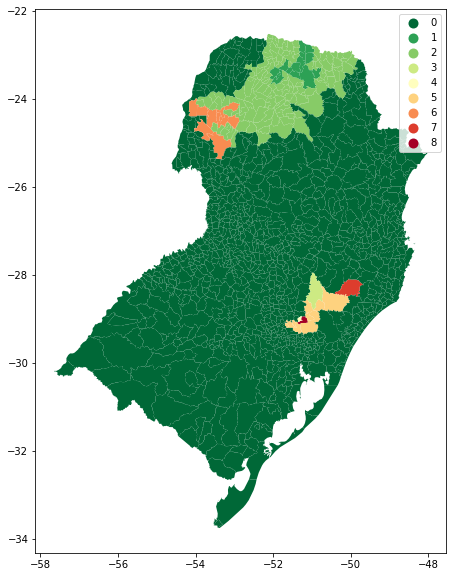

In [54]:
dados_cluster_sul.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'